## 导入必要的安装包

In [1]:
import pandas as pd
import numpy as np
import tushare as ts
import os 
from tqdm import tqdm
import glob
ts.set_token('0948b6427e46bb1bc7fa60b52df96ab0080b9d4ff80209a5fee99277')
debug = False
from datetime import datetime 
pro = ts.pro_api()

In [2]:
# !pip install openpyxl

## 生成Alpha因子的基础函数

In [3]:
def ts_sum(df, window=10):
    return df.rolling(window).sum()

def sma(df, window=10):
    return df.rolling(window).mean()

def ts_min(df, window=10):
    return df.rolling(window).min()

def ts_median(df, window=10):
    return df.rolling(window).median()

def ts_max(df, window=10):
    return df.rolling(window).max()

def delta(df, period=1):
    return df.diff(period)

def delay(df, period=1):
    return df.shift(period)

def rank(df):
    return df.rank(axis=1, pct=True)

def ts_argmax(df, window=10):
    return df.rolling(window).apply(np.argmax) + 1 


## 一系列Alpha因子

In [4]:

class AlphaLib(object):
    def __init__(self, daily_info):
        self.open = daily_info['open']
        self.high = daily_info['high']
        self.low = daily_info['low']
        self.close = daily_info['close']
        self.vwap = daily_info['vwap'] 
        self.volume = daily_info['volume'] 
        self.amount = daily_info['amount']

    def calcu_alpha(self):
        alpha_dict={}
        alpha_dict['alpha01']=((self.close/sma(self.close,10)-1)*self.amount).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha02']=sma(self.amount,5).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha06']=sma((self.close/sma(self.close, 5)-1)*self.amount,5).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha07']=ts_max((self.close/sma(self.close, 15)-1)*self.amount,15).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha08']=ts_min((self.close/ts_max(self.close, 60)-1)*self.amount,10).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha09']=ts_max((self.close/ts_min(self.close, 60)-1)*self.amount,50).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha10']=ts_max((self.close/ts_min(self.close, 20)-1)*self.amount,15).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha12']=ts_max((ts_max(self.high,30)/ts_min(self.low, 30)-1)*self.amount,20).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha13']=ts_max(self.high-self.low, 30)/ts_min(self.close+self.open, 30)
        alpha_dict['alpha14']=ts_sum(self.amount*(self.close-self.open), 5)
        alpha_dict['alpha15']=ts_max(self.amount*(self.high-self.low), 15)
        alpha_dict['alpha16']=ts_sum(self.amount*(self.close-self.vwap), 5)
        alpha_dict['alpha17']=ts_min(self.amount*(self.low-self.vwap), 15)
        alpha_dict['alpha18']=ts_min(self.amount*(self.open-self.vwap), 15)
        alpha_dict['alpha19']=ts_min(self.amount*(self.open-self.low), 10)
        alpha_dict['alpha20']=ts_max(self.amount*(self.close-self.low), 10)
        alpha_dict['alpha21']=ts_median(self.amount,15)/ts_sum(self.amount,15)
        alpha_dict['alpha23']=ts_max(self.amount,15)/ts_min(self.amount,10)
        alpha_dict['alpha24']=ts_sum(self.amount.div(self.amount.sum(1),axis=0),5)
        alpha_dict['alpha28']=(ts_max(self.close,5)/delay(self.close,5))*ts_min(self.close,5)/self.close
      
        tmp2=abs((self.close-self.open)/(self.high-self.low+0.01))
        alpha_dict['alpha29']=ts_max(tmp2,6)/ts_min(tmp2,6)
        alpha_dict['alpha30']=tmp2/delay(tmp2,4)

        tmp3=abs((self.low-self.open)/(self.close-self.low+0.01))
        alpha_dict['alpha31']=ts_max(tmp3,4)/ts_min(tmp3,4)

        tmp4=abs((self.high-self.open)/(self.close-self.low+0.01))
        alpha_dict['alpha32']=ts_max(tmp4,2)/ts_min(tmp4,2)
        
        alpha_dict['alpha_w_005'] = (rank((self.open - (ts_sum(self.vwap, 10) / 10))) * (-1 * abs(rank((self.close - self.vwap)))))
    
        return alpha_dict
        

## 生成训练集

In [5]:
import pandas as pd
price_PD_total = pd.read_csv('./data/price_PD.csv', dtype = {'trade_date': 'str'})
price_PD_total = price_PD_total.drop_duplicates(['ts_code', 'trade_date']).sort_values(['ts_code', 'trade_date']).reset_index(drop=True)
all_stock = pro.stock_basic()
all_stock = all_stock[['ts_code','name','market']]
price_PD_total = pd.merge(price_PD_total,all_stock,how='left',on='ts_code')
price_PD_total = price_PD_total[['ts_code', 'name','market', 'trade_date', 'open', 'high', 'low', 'close', 'pre_close',
       'change', 'pct_chg', 'vol', 'amount']]



In [9]:
indus = pd.read_csv('./data/a_stock_industry.csv',encoding='gbk')
indus = indus[['windcode','申万行业L1','申万行业L2','申万行业L3']]
indus.columns = ['ts_code','indus1','indus2','indus3']
indus.head()

,ts_code,indus1,indus2,indus3
0,000001.SZ,银行,银行Ⅱ,银行Ⅲ
1,000002.SZ,房地产,房地产开发Ⅱ,房地产开发Ⅲ
2,000004.SZ,计算机,计算机应用,IT服务
3,000005.SZ,公用事业,环保工程及服务Ⅱ,环保工程及服务Ⅲ
4,000006.SZ,房地产,房地产开发Ⅱ,房地产开发Ⅲ


In [10]:
##拼接行业，只保留主板、中小板、创业板，去除ST股票
price_PD_total = pd.merge(price_PD_total,indus,how='left',on='ts_code')
price_PD_total = price_PD_total[price_PD_total.market.isin(['主板','中小板','创业板'])]
price_PD_total = price_PD_total[~price_PD_total.name.str.contains('ST')].reset_index(drop=True)
price_PD_total.head()

,ts_code,name,market,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,indus1,indus2,indus3
0,000001.SZ,平安银行,主板,20150105,10.1514,10.3355,9.9038,10.1704,10.0562,0.1142,1.1356,2860436.43,4.565388e+06,银行,银行Ⅱ,银行Ⅲ
1,000001.SZ,平安银行,主板,20150106,10.0625,10.4053,9.8720,10.0181,10.1704,-0.1523,-1.4975,2166421.40,3.453446e+06,银行,银行Ⅱ,银行Ⅲ
2,000001.SZ,平安银行,主板,20150107,9.8784,10.0498,9.7133,9.8276,10.0181,-0.1905,-1.9016,1700120.67,2.634796e+06,银行,银行Ⅱ,银行Ⅲ
3,000001.SZ,平安银行,主板,20150108,9.8403,9.8847,9.4594,9.4975,9.8276,-0.3301,-3.3589,1407714.21,2.128003e+06,银行,银行Ⅱ,银行Ⅲ
4,000001.SZ,平安银行,主板,20150109,9.4594,10.0752,9.3388,9.5737,9.4975,0.0762,0.8023,2508500.23,3.835378e+06,银行,银行Ⅱ,银行Ⅲ


In [11]:
##计算开盘涨幅
price_PD_total['open_up'] = price_PD_total.groupby('ts_code').open.shift(1)/price_PD_total.groupby('ts_code').close.shift(0)

In [12]:
#t收盘买 t+1收盘卖
price_PD_total['ret1'] = price_PD_total.groupby('ts_code').close.shift(-1)/price_PD_total.groupby('ts_code').close.shift(0) 
#t+1开盘买 t+2收盘卖
price_PD_total['ret2'] = price_PD_total.groupby('ts_code').close.shift(-2)/price_PD_total.groupby('ts_code').open.shift(-1) 
#t+1开盘买 t+2开盘卖
# price_PD_total['ret3'] = price_PD_total.groupby('ts_code').open.shift(-3)/price_PD_total.groupby('ts_code').open.shift(-1) 
# #t+1开盘买 t+3收盘卖
# price_PD_total['ret4'] = price_PD_total.groupby('ts_code').close.shift(-3)/price_PD_total.groupby('ts_code').open.shift(-1)
# #t+1开盘买 t+4收盘卖
# price_PD_total['ret5'] = price_PD_total.groupby('ts_code').close.shift(-4)/price_PD_total.groupby('ts_code').open.shift(-1)

price_PD_total['ret'] = price_PD_total['ret2'].copy()



In [13]:
price_PD_wfq = pd.read_csv('./data/price_PD_2015至今_未复权.csv')
price_PD_wfq.trade_date = price_PD_wfq.trade_date.astype('str')
price_PD_wfq = price_PD_wfq.drop_duplicates(['ts_code', 'trade_date']).sort_values(['ts_code', 'trade_date']).reset_index(drop=True)
price_PD_wfq['vwap'] = price_PD_wfq.amount/price_PD_wfq.vol
price_PD_wfq = price_PD_wfq[price_PD_wfq.ts_code.isin(price_PD_total.ts_code.unique())]
price_PD_wfq.tail()

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,vwap
6220326,605599.SH,20220909,10.09,10.22,9.22,10.02,10.22,-0.20,-1.9569,58236.31,57322.643,0.984311
6220327,605599.SH,20220913,9.79,10.08,9.79,9.98,10.02,-0.04,-0.3992,31553.39,31488.568,0.997946
6220328,605599.SH,20220914,9.90,9.92,9.77,9.85,9.98,-0.13,-1.3026,18402.20,18093.121,0.983204
6220329,605599.SH,20220915,9.89,9.89,9.61,9.69,9.85,-0.16,-1.6244,14409.77,14020.617,0.972994
6220330,605599.SH,20220916,9.64,9.70,9.38,9.41,9.69,-0.28,-2.8896,14882.43,14157.309,0.951277


In [14]:
daily_info = {}
daily_info['open'] = price_PD_wfq.pivot('trade_date', 'ts_code', 'open')
daily_info['close'] = price_PD_wfq.pivot('trade_date', 'ts_code', 'close')
daily_info['high']  = price_PD_wfq.pivot('trade_date', 'ts_code', 'high')
daily_info['low']  = price_PD_wfq.pivot('trade_date', 'ts_code', 'low')
daily_info['amount']  = price_PD_wfq.pivot('trade_date', 'ts_code', 'amount')
daily_info['volume']  = price_PD_wfq.pivot('trade_date', 'ts_code', 'vol')
daily_info['vwap']  = (daily_info['amount']*1000)/(daily_info['volume']*100+1) 



In [15]:
del price_PD_wfq

In [16]:
tmp_class = AlphaLib(daily_info)
alpha_dict = tmp_class.calcu_alpha()

In [17]:
data = pd.DataFrame()
for k, v in tqdm(alpha_dict.items()):
    tmp = v.unstack().reset_index().rename(columns={0:k})
    if len(data) == 0:
        data = tmp
    else:
        data = pd.merge(data, tmp, how='left', on=['ts_code', 'trade_date'])

100%|██████████| 25/25 [02:47<00:00,  6.69s/it]


In [18]:
data = pd.merge(data, price_PD_total[['trade_date', 'ts_code','name', 'ret1', 'ret2', \
                                    'ret','open_up']], how='left', on=['trade_date', 'ts_code'])

In [19]:
price_PD_total.columns

Index(['ts_code', 'name', 'market', 'trade_date', 'open', 'high', 'low',
       'close', 'pre_close', 'change', 'pct_chg', 'vol', 'amount', 'indus1',
       'indus2', 'indus3', 'open_up', 'ret1', 'ret2', 'ret'],
      dtype='object')

In [20]:
del price_PD_total

In [21]:
train = data.copy()
train = train[train.trade_date < '20200401']#.dropna()

train['ret_rank'] = train.groupby('trade_date').ret.rank(pct=True)
train = train[~train.ret_rank.isna()].reset_index(drop=True)

from sklearn.model_selection import KFold,GroupKFold,train_test_split

kfold = KFold(n_splits = 5, shuffle = True, random_state = 42)

enumsplit = []
for fold, (trn_ind, val_ind) in enumerate(kfold.split(train)):
#     enumsplit.append([trn_ind[int(0.025*len(trn_ind)):int(0.975*len(trn_ind))], val_ind])   ##避免泄露
    enumsplit.append([trn_ind, val_ind])  ##数据存在一点点泄露
enumsplit

[[array([      0,       1,       2, ..., 3625332, 3625333, 3625334]),
  array([     12,      13,      19, ..., 3625324, 3625327, 3625330])],
 [array([      3,       4,       6, ..., 3625331, 3625332, 3625333]),
  array([      0,       1,       2, ..., 3625316, 3625328, 3625334])],
 [array([      0,       1,       2, ..., 3625331, 3625333, 3625334]),
  array([      3,      18,      23, ..., 3625326, 3625329, 3625332])],
 [array([      0,       1,       2, ..., 3625331, 3625332, 3625334]),
  array([      6,      10,      14, ..., 3625322, 3625325, 3625333])],
 [array([      0,       1,       2, ..., 3625332, 3625333, 3625334]),
  array([      4,       8,      15, ..., 3625310, 3625313, 3625331])]]

In [22]:
train_type = True
params={
    'num_leaves': 256,
    'max_bin': 200, 
    'lambda_l1':1.0,
    'lambda_l2':0.5,
    'min_data_in_leaf': 100,
    'learning_rate': 0.05,
    'min_sum_hessian_in_leaf': 0.00446,
    'bagging_fraction': 0.75, 
    'bagging_freq': 10, 
    'max_depth': -1,
    'seed': 89,
    'feature_fraction': 0.65,
    'boosting_type': 'gbdt',
    'verbose': 1,
    'objective':'regression', 
    'n_jobs':4
}

In [23]:
train.columns

Index(['ts_code', 'trade_date', 'alpha01', 'alpha02', 'alpha06', 'alpha07',
       'alpha08', 'alpha09', 'alpha10', 'alpha12', 'alpha13', 'alpha14',
       'alpha15', 'alpha16', 'alpha17', 'alpha18', 'alpha19', 'alpha20',
       'alpha21', 'alpha23', 'alpha24', 'alpha28', 'alpha29', 'alpha30',
       'alpha31', 'alpha32', 'alpha_w_005', 'name', 'ret1', 'ret2', 'ret',
       'open_up', 'ret_rank'],
      dtype='object')

In [24]:
features = ['alpha01', 'alpha02', 'alpha06', 'alpha07',
       'alpha08', 'alpha09', 'alpha10', 'alpha12', 'alpha13', 'alpha14',
       'alpha15', 'alpha16', 'alpha17', 'alpha18', 'alpha19', 'alpha20',
       'alpha21', 'alpha23', 'alpha24', 'alpha28', 'alpha29', 'alpha30',
       'alpha31', 'alpha32', 'alpha_w_005']


## 模型训练

In [25]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

modellist = []
y = train['ret_rank']
# y = train['ret']

oof_predictions = np.zeros(train.shape[0])

for fold, (trn_ind, val_ind) in enumerate(enumsplit):
    print(f'Training fold {fold + 1}')
    x_train, x_val = train.iloc[trn_ind], train.iloc[val_ind]
    y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
    train_dataset = lgb.Dataset(x_train[features], y_train)
    val_dataset = lgb.Dataset(x_val[features], y_val)
    if train_type:
#         model = lgb.train(params = params,
#                           num_boost_round=1000,
#                           train_set = train_dataset, 
#                           valid_sets = [train_dataset, val_dataset], 
#                           verbose_eval = 250,
#                           early_stopping_rounds=50)
        model = lgb.LGBMRegressor()
        model.fit(x_train[features],y_train)
    else:
        model = lgb.Booster(model_file=saving_path_name) 
    modellist.append(model)
    oof_predictions[val_ind] = model.predict(x_val[features])
    print(f'fold RMSPE is {mean_squared_error(y_val, oof_predictions[val_ind])**0.5}')
    corrr_score = np.corrcoef([y_val, oof_predictions[val_ind]])[0,1]
    print(f'fold CORR is {corrr_score}')

rmspe_score = mean_squared_error(y, oof_predictions)**0.5
print(f'Our out of folds RMSPE is {rmspe_score}')
corrr_score = np.corrcoef([y, oof_predictions])[0,1]
print(f'Our out of folds CORR is {corrr_score}')

Training fold 1
fold RMSPE is 0.286509222398292
fold CORR is 0.11936122489021278
Training fold 2
fold RMSPE is 0.28654147120494905
fold CORR is 0.12227615499837562
Training fold 3
fold RMSPE is 0.2867997867638584
fold CORR is 0.11795181941234198
Training fold 4
fold RMSPE is 0.28676295951306147
fold CORR is 0.12010387732492186
Training fold 5
fold RMSPE is 0.2865455477703823
fold CORR is 0.118744653956609
Our out of folds RMSPE is 0.2866318240611408
Our out of folds CORR is 0.11968449657718665


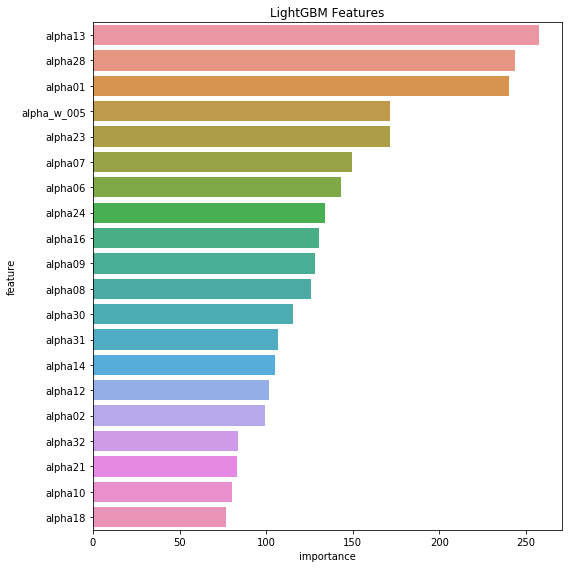

In [26]:
def print_gbm_model_feature_importance(model):
    feature_names = features
    try:
        importances = list(model.feature_importances_)
    except:
        importances = list(model.feature_importance())
    feature_importances = [(feature,round(importance)) for feature,importance in zip(feature_names,importances)]
    feature_importances = sorted(feature_importances,key=lambda x:x[1],reverse=True)
    #print(feature_importances)
    return feature_importances
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance_df = []
for model in modellist:
    feature_importance_df_ = print_gbm_model_feature_importance(model)
    feature_importance_df_ = pd.DataFrame(feature_importance_df_)
    feature_importance_df_.columns = ["feature", "importance"]
    feature_importance_df.append(feature_importance_df_)
feature_importance_df = pd.concat(feature_importance_df)
feature_importance_df = feature_importance_df.groupby('feature')['importance'].mean().reset_index()

sss = feature_importance_df.sort_values(by="importance", ascending=False).head(20)

plt.figure(figsize=(8,8))
sns.barplot(x="importance", y="feature", 
            data=sss)
plt.title('LightGBM Features')
plt.tight_layout()

## 模型预测和收益pnl

In [27]:
num = 30
test = data.copy()
test = test[(test.open_up<1.05)&(test.open_up>0.95)] 
test = test[test.trade_date > '20200401']
pred = np.zeros(test.shape[0])
for model in modellist:
    pred += model.predict(test[features])
test['pred'] = pred
date_calc = sorted(test.trade_date.unique())



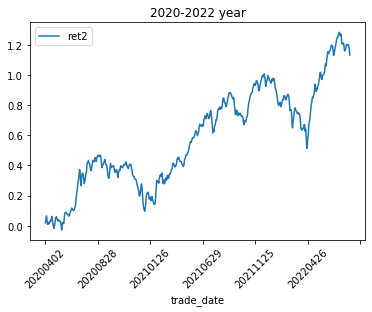

In [28]:
## 考虑t+1开盘买 t+2收盘卖的收益情况
tmp = test.copy()
tmp = tmp.groupby('trade_date').apply(lambda x: x.sort_values('pred', ascending = False).head(num)).reset_index(drop=True)
ret_pd1 = pd.DataFrame(tmp.groupby('trade_date').ret2.mean() - 1.0015)
(ret_pd1.loc['20200401':'20230101',] ).cumsum().plot(rot=45, title = '2020-2022 year')


In [29]:
# ## 考虑t收盘买 t+1收盘卖的收益情况
# tmp = test.copy()
# tmp = tmp.groupby('trade_date').apply(lambda x: x.sort_values('pred', ascending = False).head(num)).reset_index(drop=True)
# ret_pd2 = pd.DataFrame(tmp.groupby('trade_date').ret1.mean() - 1.0015)
# (ret_pd2.loc['20200401':'20220501',] ).cumsum().plot(rot=45, title = '2020-2022 year')


## 计算收益相关评价指标

In [30]:
def max_dd(returns):
    """Assumes returns is a pandas Series"""
    r = returns.cumsum()+1
    dd = r.div(r.cummax()).sub(1)
    mdd = dd.min()
    end = returns.index[dd.argmin()]
    start = returns.index[r.loc[:end].argmax()]
    return mdd, start, end

def cal_sell_turnover(tmp):
    stock = pd.DataFrame(tmp.groupby('trade_date').apply(lambda x: set(x.ts_code))).rename(columns={0:'stock_list'})
    stock['stock_list_shift1'] = stock.stock_list.shift(1)
    stock = stock.dropna()
    freq = []
    for i in range(len(stock)):
        freq.append(1 - len(stock.iloc[i]['stock_list'] & stock.iloc[i]['stock_list_shift1'])/len(stock.iloc[i]['stock_list']))
    stock['freq'] = freq
    return stock['freq'].mean()

def max_dd_month(ret_PD):
    ret2_month = ret_PD.reset_index()
    ret2_month['month'] = [str(xx)[:6] for xx in ret2_month['trade_date']]
    ret2_month = ret2_month.groupby('month')['ret'].sum()
    ret2_month = ret2_month.sort_values()
    return [ret2_month.head(1).values[0],ret2_month.head(1).index[0],\
            (ret2_month>0).sum()/len(ret2_month),ret2_month[ret2_month>=0].mean(),\
            ret2_month[ret2_month<0].mean()]

def calc_pfmc(ret_PD):
    performance = []
    ret_PD.columns = ['ret']
    returnlist = ret_PD['ret']
    ret_year = (returnlist.mean())*252
    ret_sharpe = (returnlist.mean())/returnlist.std()*((252)**0.5)
    month_pfmc = max_dd_month(ret_PD)

    winratio = (returnlist>0).sum()/(returnlist!=0).sum()
    std = returnlist.std()
    
    ret2_len = pd.DataFrame(tmp.groupby('trade_date').ret.count())
    ret2_len = ret2_len.reindex(date_calc).fillna(0)
    stock_pct = ret2_len.mean().values[0]

    turnover = cal_sell_turnover(tmp)
    performance.append(['LGB',ret_year,ret_sharpe,std,winratio,turnover,stock_pct]+month_pfmc)
    performance = pd.DataFrame(performance,columns = ['group_name','return','sharpe',\
                    'std','winratio','turnover','stock_num','mdd_month','mdd_month_No',\
                    'month_winratio','month_win_ret','month_lose_ret'])

    return performance

In [31]:
calc_pfmc(ret_pd1)

,group_name,return,sharpe,std,winratio,turnover,stock_num,mdd_month,mdd_month_No,month_winratio,month_win_ret,month_lose_ret
0,LGB,0.491101,1.583271,0.01954,0.5506,0.770962,29.897084,-0.178334,202201,0.633333,0.103528,-0.075888


In [33]:
## 看某天的股票持仓
tmp[tmp.trade_date=='20220908'][['ts_code','name','trade_date','pred','ret','ret1','ret2']]

,ts_code,name,trade_date,pred,ret,ret1,ret2
17310,600593.SH,大连圣亚,20220908,2.849971,0.967784,0.973650,0.967784
17311,603259.SH,药明康德,20220908,2.837262,0.898235,1.025260,0.898235
17312,000858.SZ,五粮液,20220908,2.795919,1.028408,1.015025,1.028408
17313,003033.SZ,征和工业,20220908,2.777634,0.983781,0.977867,0.983781
17314,600745.SH,闻泰科技,20220908,2.764145,0.993719,1.004801,0.993719
17315,000661.SZ,长春高新,20220908,2.762954,1.010765,1.017488,1.010765
17316,002633.SZ,申科股份,20220908,2.741842,0.980392,0.954590,0.980392
17317,300896.SZ,爱美客,20220908,2.735663,1.058485,1.033833,1.058485
17318,300905.SZ,宝丽迪,20220908,2.727132,0.997278,0.995621,0.997278
17319,603501.SH,韦尔股份,20220908,2.721909,1.014575,1.013911,1.014575


In [34]:
## 计算沪深300的收益
df300 = pro.index_daily(ts_code='000300.SH', start_date=ret_pd1.index[0], end_date=ret_pd1.index[-1])
df300 = df300[['trade_date','pct_chg']].set_index('trade_date').sort_index()
df300

,pct_chg
trade_date,
20200402,1.6178
20200403,-0.5707
20200407,2.2838
20200408,-0.4654
20200409,0.3298
...,...
20220909,1.3895
20220913,0.4233
20220914,-1.1130


In [35]:
ret_pd_concat = pd.merge(ret_pd1,df300/100,left_index=True, right_index=True)
ret_pd_concat.columns = ['ret','df300']
ret_pd_concat['diff'] = ret_pd_concat['ret'] - ret_pd_concat['df300']
ret_pd_concat

,ret,df300,diff
trade_date,,,
20200402,0.019341,0.016178,0.003163
20200403,0.020181,-0.005707,0.025888
20200407,0.026256,0.022838,0.003418
20200408,-0.027969,-0.004654,-0.023315
20200409,-0.028355,0.003298,-0.031653
...,...,...,...
20220909,-0.009217,0.013895,-0.023112
20220913,-0.013566,0.004233,-0.017799
20220914,-0.045689,-0.011130,-0.034559


In [36]:
ret_pd_concat.corr()

,ret,df300,diff
ret,1.000000,0.012201,0.843188
df300,0.012201,1.000000,-0.527291
diff,0.843188,-0.527291,1.000000


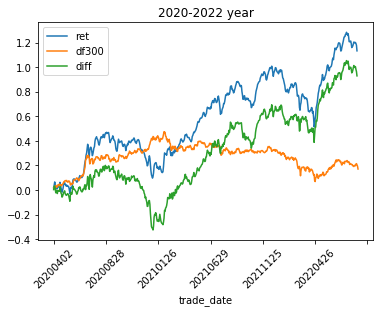

In [37]:
(ret_pd_concat[['ret','df300','diff']].cumsum()).plot(rot=45, title = '2020-2022 year')


## 计算oof的收益情况和PNL；实际参考意义不大，因为模型会过拟合训练集

,group_name,return,sharpe,std,winratio,turnover,stock_num,mdd_month,mdd_month_No,month_winratio,month_win_ret,month_lose_ret
0,LGB,1.553251,2.938578,0.033297,0.612069,0.80102,29.976507,-0.207242,201904,0.650794,0.224839,-0.061524


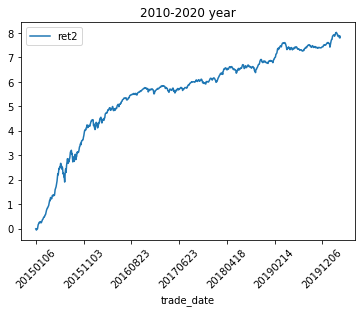

In [38]:

train['pred'] = oof_predictions

date_calc = sorted(train.trade_date.unique())
num = 30
tmp = train.copy()
tmp = tmp[(tmp.open_up<1.05)&(tmp.open_up>0.95)]

tmp = tmp.groupby('trade_date').apply(lambda x: x.sort_values('pred', ascending = False).head(num)).reset_index(drop=True)
ret_pd = pd.DataFrame(tmp.groupby('trade_date').ret2.mean() - 1.0015)
(ret_pd.loc['20100101':'20200401',] ).cumsum().plot(rot=45, title = '2010-2020 year')

calc_pfmc(ret_pd)

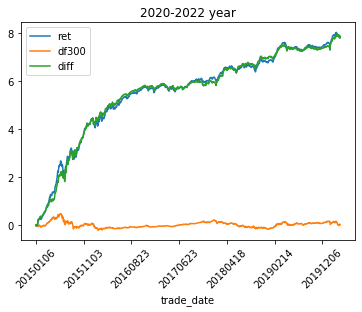

In [39]:
df300 = pro.index_daily(ts_code='000300.SH', start_date=ret_pd.index[0], end_date=ret_pd.index[-1])
df300 = df300[['trade_date','close']].set_index('trade_date').sort_index()
df300 = df300/df300.head(1).values
ret_pd_concat = pd.merge(ret_pd.cumsum(),df300-1,left_index=True, right_index=True)
ret_pd_concat.columns = ['ret','df300']
ret_pd_concat['diff'] = ret_pd_concat[['ret']]-ret_pd_concat[['df300']].values
(ret_pd_concat[['ret','df300','diff']]).plot(rot=45, title = '2020-2022 year')


In [40]:
sss = ret_pd_concat[['ret']]- ret_pd_concat[['df300']].values
calc_pfmc(sss.diff())


,group_name,return,sharpe,std,winratio,turnover,stock_num,mdd_month,mdd_month_No,month_winratio,month_win_ret,month_lose_ret
0,LGB,1.554476,2.575204,0.038025,0.568966,0.80102,29.976507,-0.218466,201904,0.730159,0.199223,-0.076432
